In [1]:
!pip install transformers tqdm scikit-learn
!pip install librosa soundfile
!pip install opencv-python moviepy
!pip install torch torchvision torchaudio transformers scikit-learn
!pip install pandas numpy matplotlib seaborn
!pip install xgboost pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
# System & Utility
import os
import re

# Data Handling
import numpy as np
import pandas as pd

# Audio Processing
import librosa
import soundfile as sf
import torchaudio

# Video Processing
import cv2
import moviepy.editor as mpy
import subprocess
from torchvision import models, transforms
import xgboost as xgb
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress Bar
from tqdm import tqdm

# Machine Learning & Deep Learning
import torch
import torchvision
import transformers

# Transformers
from transformers import BertTokenizer, BertModel
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# Scikit-learn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

print("All libraries imported successfully!")


  if event.key is 'enter':



All libraries imported successfully!


In [3]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -q '/content/drive/MyDrive/IEMOCAP_full_release.zip' -d '/content/IEMOCAP_full_release'
!rm -rf /content/IEMOCAP_full_release/__MACOSX
!ls /content/IEMOCAP_full_release/IEMOCAP_full_release

Mounted at /content/drive
Documentation  Session1  Session2  Session3  Session4  Session5


## Text Modality

In [4]:
data_path = '/content/IEMOCAP_full_release/IEMOCAP_full_release'
# Extract utterances and texts
transcripts = []
for session in [f'Session{i}' for i in range(1, 6)]:
    trans_dir = os.path.join(data_path, session, 'dialog', 'transcriptions')
    for file in os.listdir(trans_dir):
        if file.endswith('.txt'):
            with open(os.path.join(trans_dir, file), 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split(':', 1)
                    if len(parts) == 2:
                        utt_id, text = parts
                        transcripts.append({'utterance_id': utt_id.strip(), 'text': text.strip()})

# Extract emotion labels, merge 'exc' into 'hap'
valid_emotions = {'ang', 'hap', 'sad', 'neu', 'exc'}
label_dict = {}
for session in [f'Session{i}' for i in range(1, 6)]:
    emo_eval_dir = os.path.join(data_path, session, 'dialog', 'EmoEvaluation')
    for file in os.listdir(emo_eval_dir):
        if file.endswith('.txt'):
            with open(os.path.join(emo_eval_dir, file), 'r') as f:
                for line in f:
                    match = re.match(r'\[.*?\]\s+(\S+)\s+(\w+)', line)
                    if match:
                        utt_id, emotion = match.groups()
                        if emotion in valid_emotions:
                            if emotion == 'exc':
                                emotion = 'hap'
                            label_dict[utt_id] = emotion

texts, utt_ids, y = [], [], []
for item in transcripts:
    utt_id = item['utterance_id'].split()[0]
    if utt_id in label_dict:
        texts.append(item['text'])
        utt_ids.append(utt_id)
        y.append(label_dict[utt_id])
print(f"Number of labeled utterances: {len(y)}")

Number of labeled utterances: 5531


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

batch_size = 32
cls_embeddings = []

with torch.no_grad():
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
        outputs = model(**inputs)
        cls_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        cls_embeddings.append(cls_emb)

cls_embeddings = np.vstack(cls_embeddings)
np.save('iemocap_text_cls_embeddings.npy', cls_embeddings)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

  0%|          | 0/173 [00:00<?, ?it/s]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)

100%|██████████| 173/173 [03:46<00:00,  1.31s/it]


In [6]:
mean_embeddings = []

with torch.no_grad():
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
        outputs = model(**inputs)
        last_hidden = outputs.last_hidden_state
        attention_mask = inputs['attention_mask']
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
        sum_embeddings = torch.sum(last_hidden * mask_expanded, 1)
        sum_mask = mask_expanded.sum(1)
        mean_pooled = sum_embeddings / sum_mask
        mean_embeddings.append(mean_pooled.cpu().numpy())

mean_embeddings = np.vstack(mean_embeddings)
np.save('iemocap_text_mean_embeddings.npy', mean_embeddings)


100%|██████████| 173/173 [03:41<00:00,  1.28s/it]


In [7]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Emotion classes:", le.classes_)

# Choose which embeddings to use: cls_embeddings or mean_embeddings
X = np.load('iemocap_text_mean_embeddings.npy')  # or 'iemocap_text_cls_embeddings.npy'

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': [None, 'balanced']
}

svc = SVC(probability=True, random_state=42)
grid = GridSearchCV(svc, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)

y_pred = grid.predict(X_test)
svc_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", svc_acc)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train, y_train)
lr_acc = accuracy_score(y_test, lr.predict(X_test))
print("Logistic Regression Accuracy:", lr_acc)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
rf_acc = accuracy_score(y_test, rf.predict(X_test))
print("Random Forest Accuracy:",rf_acc )

# MLP (Neural Network)
mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
mlp_acc = accuracy_score(y_test, mlp.predict(X_test))
print("MLP Accuracy:", mlp_acc)


ensemble = VotingClassifier(
    estimators=[
        ('svm', grid.best_estimator_),
        ('rf', rf),
        ('mlp', mlp)
    ],
    voting='soft'
)
ensemble.fit(X_train, y_train)
ensemble_acc = accuracy_score(y_test, ensemble.predict(X_test))
print("Ensemble Accuracy:", ensemble_acc)


Emotion classes: ['ang' 'hap' 'neu' 'sad']
Best parameters: {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Best CV score: 0.6810760958378942
Test Accuracy: 0.7028003613369467
Classification Report:
               precision    recall  f1-score   support

         ang       0.74      0.77      0.75       221
         hap       0.74      0.73      0.73       327
         neu       0.66      0.66      0.66       342
         sad       0.68      0.66      0.67       217

    accuracy                           0.70      1107
   macro avg       0.70      0.71      0.70      1107
weighted avg       0.70      0.70      0.70      1107

Logistic Regression Accuracy: 0.6251129177958447
Random Forest Accuracy: 0.6431797651309846
MLP Accuracy: 0.6793134598012647
Ensemble Accuracy: 0.6820234869015357



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette='viridis')



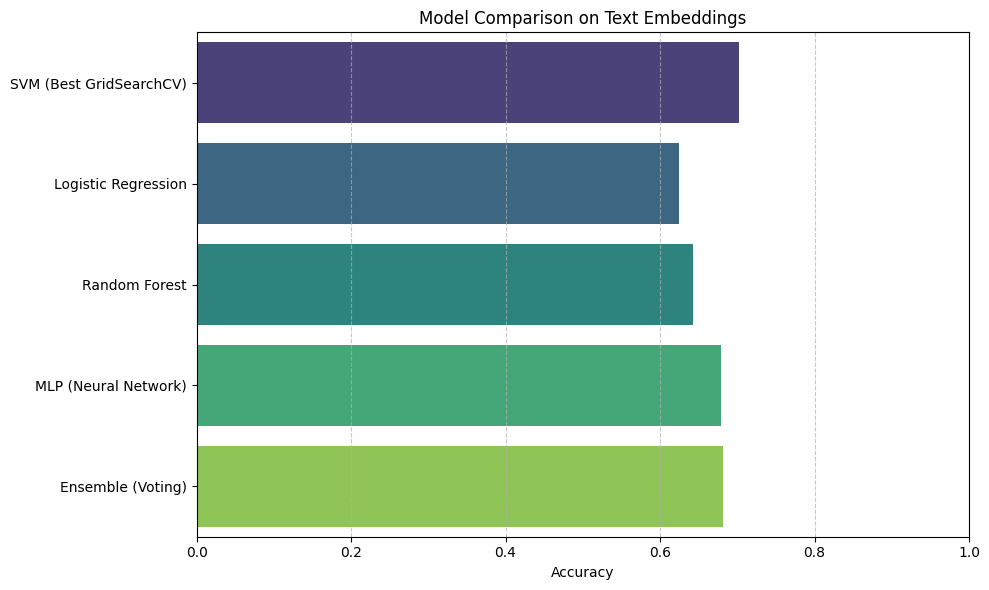

In [8]:

# Prepare data for plotting
model_names = [
    "SVM (Best GridSearchCV)",
    "Logistic Regression",
    "Random Forest",
    "MLP (Neural Network)",
    "Ensemble (Voting)"
]
accuracies = [svc_acc, lr_acc, rf_acc, mlp_acc, ensemble_acc]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=model_names, palette='viridis')
plt.xlabel("Accuracy")
plt.title("Model Comparison on Text Embeddings")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Audio Modality

In [9]:
sessions = [f'Session{i}' for i in range(1, 6)]
data_path = '/content/IEMOCAP_full_release/IEMOCAP_full_release'
records = []
valid_emotions = {'ang', 'hap', 'sad', 'neu', 'exc'}
emotion_file_count = 0
emotion_line_count = 0

for session in sessions:
    emo_eval_dir = os.path.join(data_path, session, 'dialog', 'EmoEvaluation')
    if not os.path.isdir(emo_eval_dir):
        print("Missing:", emo_eval_dir)
        continue
    for fname in os.listdir(emo_eval_dir):
        if fname.endswith('.txt'):
            emotion_file_count += 1
            with open(os.path.join(emo_eval_dir, fname), 'r') as f:
                for line in f:
                    if line.startswith('['):
                        emotion_line_count += 1
                        match = re.match(r'\[.*\]\s+(\S+)\s+([a-z]+)', line)
                        if match:
                            utt_id, emo = match.groups()
                            if emo in valid_emotions:
                                if emo == 'exc':
                                    emo = 'hap'
                                audio_folder = os.path.join(data_path, session, 'sentences/wav')
                                found = False
                                for subf in os.listdir(audio_folder):
                                    wav_path = os.path.join(audio_folder, subf, utt_id + '.wav')
                                    if os.path.exists(wav_path):
                                        records.append({'utt_id': utt_id, 'audio_path': wav_path, 'emotion': emo})
                                        found = True
                                        break
                                if not found:
                                    print(f"Audio file NOT found for {utt_id} in {audio_folder}")
                        else:
                            # This line does NOT match - print it for debugging
                            print(f"Regex did not match: {line.strip()}")

print(f"Emotion files parsed: {emotion_file_count}")
print(f"Bracketed lines found: {emotion_line_count}")
print(f"Audio records collected: {len(records)}")
print(records[:5])
df_audio = pd.DataFrame(records)
print(df_audio['emotion'].value_counts())
print(df_audio.head())


Emotion files parsed: 151
Bracketed lines found: 10039
Audio records collected: 5531
[{'utt_id': 'Ses01M_impro01_F000', 'audio_path': '/content/IEMOCAP_full_release/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F000.wav', 'emotion': 'ang'}, {'utt_id': 'Ses01M_impro01_F001', 'audio_path': '/content/IEMOCAP_full_release/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F001.wav', 'emotion': 'ang'}, {'utt_id': 'Ses01M_impro01_F007', 'audio_path': '/content/IEMOCAP_full_release/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F007.wav', 'emotion': 'ang'}, {'utt_id': 'Ses01M_impro01_F008', 'audio_path': '/content/IEMOCAP_full_release/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F008.wav', 'emotion': 'ang'}, {'utt_id': 'Ses01M_impro01_F011', 'audio_path': '/content/IEMOCAP_full_release/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F011.wav', 'emotion': 'ang'}]

In [10]:
le = LabelEncoder()
df_audio['emotion_label'] = le.fit_transform(df_audio['emotion'])
print(list(le.classes_)) # Should show ['ang', 'hap', 'neu', 'sad']

['ang', 'hap', 'neu', 'sad']


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-960h')
model = Wav2Vec2Model.from_pretrained('facebook/wav2vec2-base-960h').to(device)
model.eval()

def extract_features(audio_path, sr=16000, duration=6.0):
    y, _ = librosa.load(audio_path, sr=sr)
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))
    max_len = int(sr * duration)
    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)))
    else:
        y = y[:max_len]
    # Deep features
    inputs = processor(y, sampling_rate=sr, return_tensors='pt', padding=True)
    with torch.no_grad():
        out = model(inputs.input_values.to(device))
        mean_emb = out.last_hidden_state.mean(dim=1)
        max_emb = out.last_hidden_state.max(dim=1).values
        pooled = torch.cat([mean_emb, max_emb], dim=1).cpu().numpy().squeeze()
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)
    return np.concatenate([pooled, mfccs])

# Create feature matrix
audio_paths = df_audio['audio_path'].tolist()
X_audio = np.stack([extract_features(p) for p in tqdm(audio_paths)])
y_audio = df_audio['emotion_label'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_audio, y_audio, test_size=0.2, stratify=y_audio, random_state=42
)
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM classifier (with best practice hyperparameters)
svm = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Evaluation
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

mlp = MLPClassifier(hidden_layer_sizes=(512, 256), activation='relu', max_iter=400, random_state=42, early_stopping=True)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("MLP Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 5531/5531 [05:02<00:00, 18.26it/s]


SVM Accuracy: 0.5971093044263776
              precision    recall  f1-score   support

         ang       0.69      0.70      0.69       221
         hap       0.56      0.57      0.57       327
         neu       0.55      0.56      0.55       342
         sad       0.64      0.59      0.61       217

    accuracy                           0.60      1107
   macro avg       0.61      0.60      0.61      1107
weighted avg       0.60      0.60      0.60      1107

Confusion Matrix:
 [[154  34  27   6]
 [ 33 187  82  25]
 [ 29  80 192  41]
 [  7  33  49 128]]
MLP Accuracy: 0.5627822944896116
              precision    recall  f1-score   support

         ang       0.64      0.67      0.65       221
         hap       0.53      0.47      0.50       327
         neu       0.53      0.49      0.51       342
         sad       0.57      0.70      0.63       217

    accuracy                           0.56      1107
   macro avg       0.57      0.58      0.57      1107
weighted avg       0.56

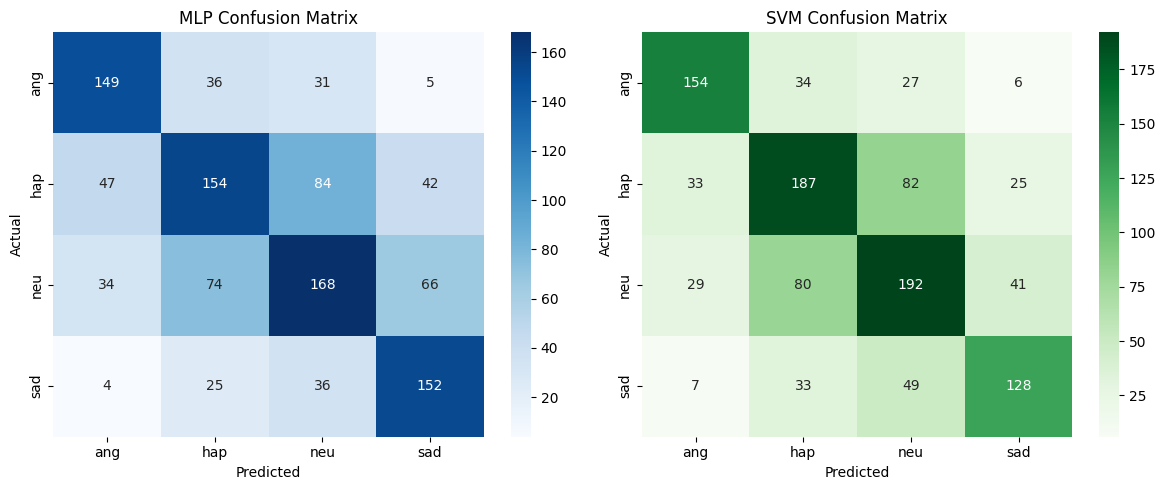

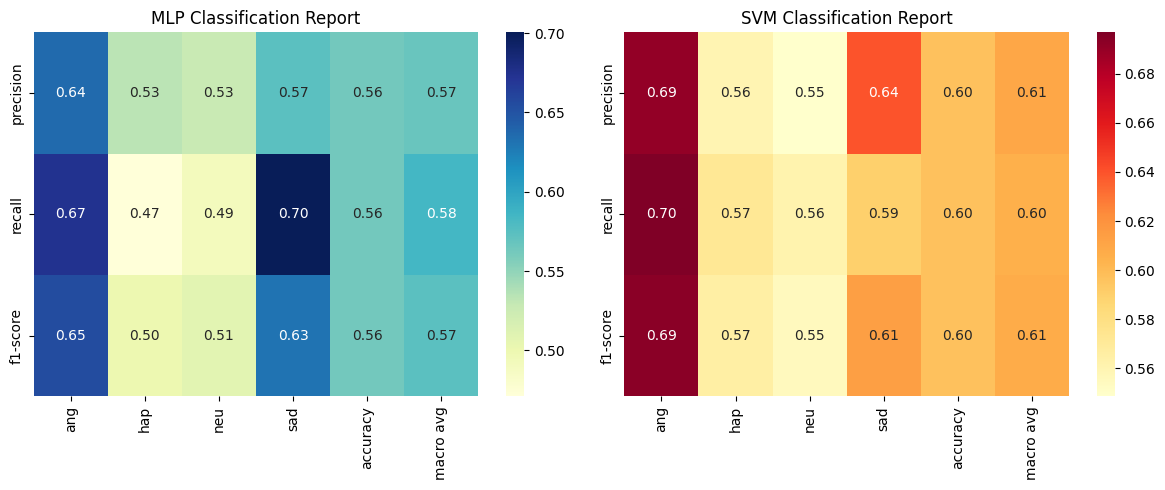

In [12]:


# 1. Plot Confusion Matrices Side-by-Side
def plot_confusion_matrices(y_true, y_pred_mlp, y_pred_svm, class_names):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    cm_mlp = confusion_matrix(y_true, y_pred_mlp, labels=range(len(class_names)))
    sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title("MLP Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    cm_svm = confusion_matrix(y_true, y_pred_svm, labels=range(len(class_names)))
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title("SVM Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

# 2. Plot Classification Reports Side-by-Side
def plot_classification_reports(y_true, y_pred_mlp, y_pred_svm, class_names):
    report_mlp = classification_report(y_true, y_pred_mlp, target_names=class_names, output_dict=True)
    report_svm = classification_report(y_true, y_pred_svm, target_names=class_names, output_dict=True)

    df_mlp = pd.DataFrame(report_mlp).iloc[:-1, :-1]
    df_svm = pd.DataFrame(report_svm).iloc[:-1, :-1]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(df_mlp, annot=True, cmap='YlGnBu', fmt=".2f", ax=axes[0])
    axes[0].set_title("MLP Classification Report")

    sns.heatmap(df_svm, annot=True, cmap='YlOrRd', fmt=".2f", ax=axes[1])
    axes[1].set_title("SVM Classification Report")

    plt.tight_layout()
    plt.show()

# 🧠 Call the functions
plot_confusion_matrices(y_test, mlp.predict(X_test), svm.predict(X_test), le.classes_)
plot_classification_reports(y_test, mlp.predict(X_test), svm.predict(X_test), le.classes_)


Why is the `neutral` emotion harder to predict?

- **Less distinctive features**: Neutral speech lacks pitch or energy variation.
- **Overlap with other emotions**: Often confused with calm happy or low-intensity sad speech.
- **Speaker inconsistency**: Some users naturally speak in a neutral tone, even during emotional utterances.
- **Bias toward expressive classes**: Models learn better from emotionally extreme patterns like anger or sadness.

## Video Modality

In [13]:
def parse_utterance_times(trans_dir):
    """Parse utterance timing information from transcription files."""
    utt_times = {}
    for fname in os.listdir(trans_dir):
        if not fname.endswith('.txt'):
            continue
        with open(os.path.join(trans_dir, fname), "r") as f:
            for line in f:
                m = re.match(r'^(\S+)\s+\[(\d+\.\d+)-(\d+\.\d+)\]:', line)
                if m:
                    utt_id = m.group(1)
                    start = float(m.group(2))
                    end = float(m.group(3))
                    utt_times[utt_id] = (start, end)
    return utt_times

# Set up paths for local environment
data_path = '/content/IEMOCAP_full_release/IEMOCAP_full_release'
session_path = os.path.join(data_path, 'Session1')
output_dir = 'utterance_videos'
os.makedirs(output_dir, exist_ok=True)

# Parse utterance times for Session1
trans_dir = os.path.join(session_path, "dialog", "transcriptions")
utt2time = parse_utterance_times(trans_dir)
print(f"Found {len(utt2time)} utterances with timing information")

Found 1819 utterances with timing information


In [14]:

# Define the improved augmentation function
def augment_features(X, y):
    """Augment features with more challenging transformations"""
    X_aug = X.copy()
    y_aug = y.copy()

    # 1. Add stronger random noise
    noise_levels = [0.05, 0.1, 0.15]  # 5%, 10%, and 15% noise
    for noise_scale in noise_levels:
        noise = np.random.normal(0, noise_scale, X.shape)
        X_aug = np.vstack([X_aug, X + noise])
        y_aug = np.hstack([y_aug, y])

    # 2. Add more varied scaling
    scale_factors = [0.7, 0.85, 1.15, 1.3]  # 30% range up and down
    for scale in scale_factors:
        X_aug = np.vstack([X_aug, X * scale])
        y_aug = np.hstack([y_aug, y])

    # 3. Add random feature dropout (simulate occlusion/missing features)
    dropout_rates = [0.1, 0.2]  # Drop 10% and 20% of features
    for rate in dropout_rates:
        X_dropped = X.copy()
        mask = np.random.rand(*X.shape) < rate
        X_dropped[mask] = 0
        X_aug = np.vstack([X_aug, X_dropped])
        y_aug = np.hstack([y_aug, y])

    # 4. Add feature permutation (simulate temporal variations)
    num_permutations = 2
    for _ in range(num_permutations):
        X_perm = X.copy()
        for i in range(len(X)):
            perm_idx = np.random.permutation(X.shape[1])[:int(0.1 * X.shape[1])]
            X_perm[i, perm_idx] = np.random.permutation(X_perm[i, perm_idx])
        X_aug = np.vstack([X_aug, X_perm])
        y_aug = np.hstack([y_aug, y])

    # 5. Combine transformations
    X_combined = X.copy()
    X_combined = X_combined * np.random.uniform(0.9, 1.1, X_combined.shape)  # Random scaling
    X_combined += np.random.normal(0, 0.05, X_combined.shape)  # Add noise
    mask = np.random.rand(*X_combined.shape) < 0.1  # Drop some features
    X_combined[mask] = 0
    X_aug = np.vstack([X_aug, X_combined])
    y_aug = np.hstack([y_aug, y])

    return X_aug, y_aug

In [15]:
   # Cell 4: Video extraction functions
   def get_full_session_video_path(session_path, utt_id):
       """Get the full path to the session video file."""
       parts = utt_id.split('_')
       fullvid = f"{parts[0]}_{parts[1]}"
       if len(parts) > 2 and not parts[1].startswith('impro'):
           fullvid += f"_{parts[2]}"
       fullvid += ".avi"
       return os.path.join(session_path, "dialog", "avi", "DivX", fullvid)

   def extract_utterance_video(full_video, out_video, start, end):
       """Extract a segment from a video file using ffmpeg."""
       cmd = [
           'ffmpeg', '-y', '-i', full_video,
           '-ss', f'{start:.2f}', '-to', f'{end:.2f}',
           '-c:v', 'copy', '-an', out_video
       ]
       subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

   # Extract video segments
   for utt_id, (start, end) in list(utt2time.items())[:1200]:  # Start with 100 for testing
       vid_path = get_full_session_video_path(session_path, utt_id)
       out_path = os.path.join(output_dir, utt_id + '.avi')
       if os.path.exists(vid_path):
           extract_utterance_video(vid_path, out_path, start, end)
       else:
           print(f"Video not found: {vid_path}")

In [17]:
   # Cell 5: Face extraction and feature extraction setup
   def extract_faces_from_video(video_path, every_nth=5, out_size=(224,224)):
       """Extract faces from video frames using OpenCV."""
       faces = []
       cap = cv2.VideoCapture(video_path)
       count = 0

       cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

       while True:
           ret, frame = cap.read()
           if not ret:
               break
           if count % every_nth == 0:
               gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
               detect = cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3)
               if len(detect) > 0:
                   (x, y, w, h) = max(detect, key=lambda x: x[2]*x[3])
                   face = frame[y:y+h, x:x+w]
                   face = cv2.resize(face, out_size)
                   faces.append(face)
           count += 1
       cap.release()
       return faces

   # Set up ResNet model
   resnet = models.resnet18(pretrained=True)
   resnet.fc = torch.nn.Identity()
   resnet.eval()
   transform = transforms.Compose([
       transforms.ToPILImage(),
       transforms.Resize((224,224)),
       transforms.ToTensor(),
       transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
   ])

  warnings.warn(

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 235MB/s]


In [18]:
# Cell 6: Process videos and extract features (cleaned)

def get_utterance_embedding(faces):
    """Extract features from faces using ResNet."""
    if len(faces) == 0:
        return np.zeros(512)
    with torch.no_grad():
        tensors = torch.stack([transform(f) for f in faces])
        features = resnet(tensors)
    return features.mean(dim=0).cpu().numpy()

# Process videos
video_files = [f for f in os.listdir(output_dir) if f.endswith('.avi')]
X_video, y_video = [], []

no_face_cnt = 0
no_label_cnt = 0

print(f"Processing {len(video_files)} video files...")

for vid_file in tqdm(video_files):
    utt_id = vid_file.replace('.avi', '')
    vid_path = os.path.join(output_dir, utt_id + '.avi')

    faces = extract_faces_from_video(vid_path)
    if len(faces) == 0:
        no_face_cnt += 1
        continue

    emb = get_utterance_embedding(faces)
    label_row = df_audio.loc[df_audio['utt_id'] == utt_id]
    if label_row.empty:
        no_label_cnt += 1
        continue

    X_video.append(emb)
    y_video.append(label_row['emotion_label'].iloc[0])

# Final summary print
print(f"\nVideo Processing Complete")
print(f"Total videos processed: {len(video_files)}")
print(f"Features extracted: {len(X_video)}")
print(f"Videos with no faces: {no_face_cnt}")
print(f"Videos with no labels: {no_label_cnt}")


Processing 1200 video files...


100%|██████████| 1200/1200 [10:11<00:00,  1.96it/s]


Video Processing Complete
Total videos processed: 1200
Features extracted: 307
Videos with no faces: 667
Videos with no labels: 226


Original data shape: (307, 512)
Unique labels: [0 1 2 3]

Fold 1/5
Training data before augmentation: (245, 512)
Training data after augmentation: (3185, 512)
Test data shape (no augmentation): (62, 512)

Training svm...
SVM Results (Fold 1):
Accuracy: 0.5645

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.86      0.55         7
           1       0.82      0.56      0.67        25
           2       0.38      0.46      0.41        13
           3       0.64      0.53      0.58        17

    accuracy                           0.56        62
   macro avg       0.56      0.60      0.55        62
weighted avg       0.63      0.56      0.58        62


Training rf...
RF Results (Fold 1):
Accuracy: 0.6613

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.75      0.72      0.73        25
           2       0.40      0.46      0

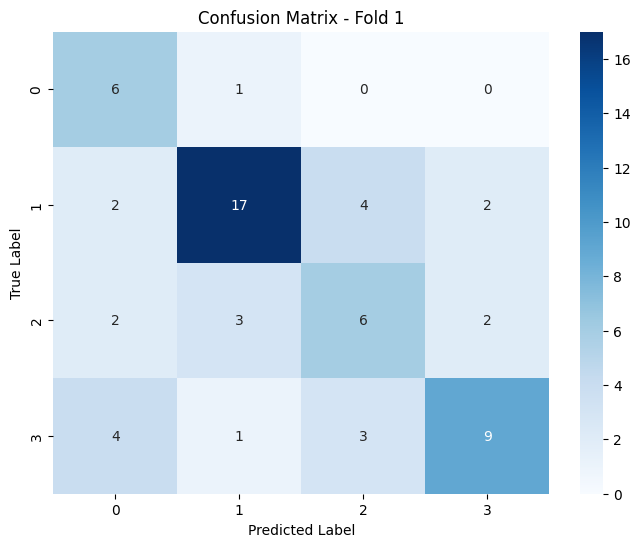


Fold 2/5
Training data before augmentation: (245, 512)
Training data after augmentation: (3185, 512)
Test data shape (no augmentation): (62, 512)

Training svm...
SVM Results (Fold 2):
Accuracy: 0.6452

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.56      0.53         9
           1       0.67      0.78      0.72        18
           2       0.62      0.50      0.56        20
           3       0.73      0.73      0.73        15

    accuracy                           0.65        62
   macro avg       0.63      0.64      0.63        62
weighted avg       0.65      0.65      0.64        62


Training rf...
RF Results (Fold 2):
Accuracy: 0.6290

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.33      0.43         9
           1       0.65      0.83      0.73        18
           2       0.67      0.40      0.50        20
           3       0.59      0.87      0.70

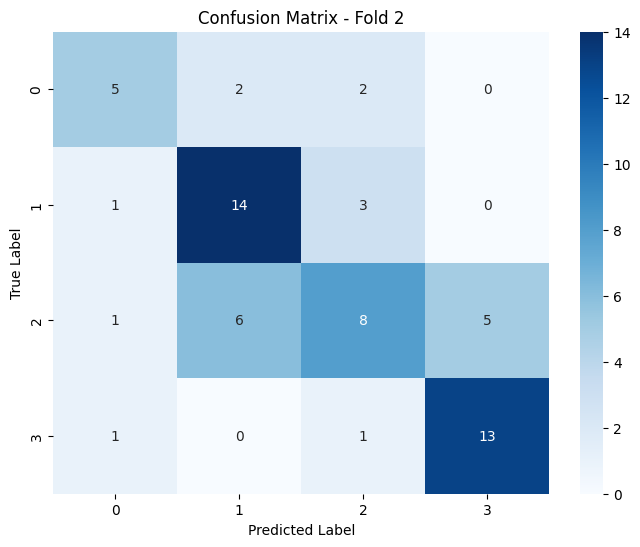


Fold 3/5
Training data before augmentation: (246, 512)
Training data after augmentation: (3198, 512)
Test data shape (no augmentation): (61, 512)

Training svm...
SVM Results (Fold 3):
Accuracy: 0.6557

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.64      0.84      0.73        19
           2       0.55      0.40      0.46        15
           3       0.67      0.75      0.71        16

    accuracy                           0.66        61
   macro avg       0.68      0.63      0.64        61
weighted avg       0.66      0.66      0.65        61


Training rf...
RF Results (Fold 3):
Accuracy: 0.6557

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.59      0.89      0.71        19
           2       0.54      0.47      0.50        15
           3       0.79      0.69      0.73

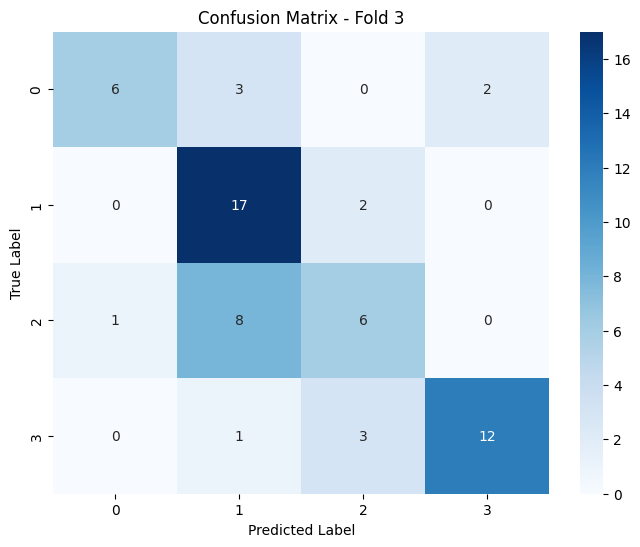


Fold 4/5
Training data before augmentation: (246, 512)
Training data after augmentation: (3198, 512)
Test data shape (no augmentation): (61, 512)

Training svm...
SVM Results (Fold 4):
Accuracy: 0.5738

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.57      0.44         7
           1       0.73      0.80      0.76        20
           2       0.43      0.46      0.44        13
           3       0.64      0.43      0.51        21

    accuracy                           0.57        61
   macro avg       0.54      0.57      0.54        61
weighted avg       0.59      0.57      0.57        61


Training rf...
RF Results (Fold 4):
Accuracy: 0.6066

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43         7
           1       0.74      0.85      0.79        20
           2       0.40      0.46      0.43        13
           3       0.69      0.52      0.59

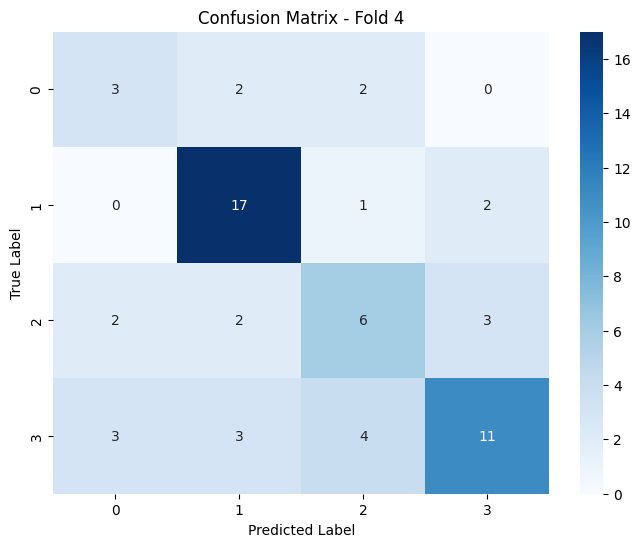


Fold 5/5
Training data before augmentation: (246, 512)
Training data after augmentation: (3198, 512)
Test data shape (no augmentation): (61, 512)

Training svm...
SVM Results (Fold 5):
Accuracy: 0.6066

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.56      0.45         9
           1       0.90      0.79      0.84        24
           2       0.50      0.38      0.43        16
           3       0.47      0.58      0.52        12

    accuracy                           0.61        61
   macro avg       0.56      0.58      0.56        61
weighted avg       0.64      0.61      0.61        61


Training rf...
RF Results (Fold 5):
Accuracy: 0.6066

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.22      0.33         9
           1       0.80      0.83      0.82        24
           2       0.50      0.38      0.43        16
           3       0.43      0.75      0.55

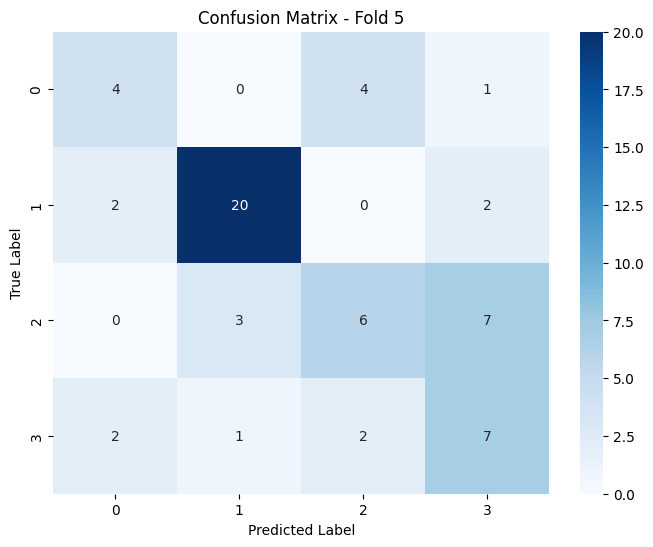


Average Scores Across 5 Folds:
SVM: 0.6091 (±0.0367)
RF: 0.6318 (±0.0233)
XGB: 0.5894 (±0.0340)
ENSEMBLE: 0.6287 (±0.0260)


In [19]:

# Main training and evaluation code with proper train/test separation
if len(X_video) > 0:
    X_video = np.stack(X_video)
    y_video = np.array(y_video)

    print("Original data shape:", X_video.shape)
    print("Unique labels:", np.unique(y_video))

    # Use 5-fold cross-validation on original data
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = {name: [] for name in ['svm', 'rf', 'xgb', 'ensemble']}

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_video)):
        print(f"\nFold {fold + 1}/5")

        # Split data first
        X_train, X_test = X_video[train_idx], X_video[test_idx]
        y_train, y_test = y_video[train_idx], y_video[test_idx]

        # Then augment ONLY the training data
        print("Training data before augmentation:", X_train.shape)
        X_train_aug, y_train_aug = augment_features(X_train, y_train)
        print("Training data after augmentation:", X_train_aug.shape)
        print("Test data shape (no augmentation):", X_test.shape)

        # Scale features using only training data statistics
        scaler = StandardScaler()
        X_train_aug = scaler.fit_transform(X_train_aug)
        X_test = scaler.transform(X_test)

        # Define classifiers with more regularization
        classifiers = {
            'svm': SVC(kernel='rbf', C=0.1, gamma='scale', class_weight='balanced', probability=True),
            'rf': RandomForestClassifier(n_estimators=200, max_depth=8, min_samples_leaf=5, class_weight='balanced', random_state=42),
            'xgb': xgb.XGBClassifier(max_depth=4, learning_rate=0.01, n_estimators=200, min_child_weight=5, eval_metric='mlogloss', random_state=42)
        }

        # Train and evaluate each classifier
        predictions = {}
        for name, clf in classifiers.items():
            print(f"\nTraining {name}...")
            # Train on augmented training data
            clf.fit(X_train_aug, y_train_aug)
            # Test on original test data
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            cv_scores[name].append(acc)
            predictions[name] = clf.predict_proba(X_test)

            print(f"{name.upper()} Results (Fold {fold + 1}):")
            print(f"Accuracy: {acc:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

        # Ensemble predictions
        ensemble_pred = np.mean([pred for pred in predictions.values()], axis=0)
        y_pred_ensemble = np.argmax(ensemble_pred, axis=1)
        acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
        cv_scores['ensemble'].append(acc_ensemble)

        print("\nENSEMBLE Results:")
        print(f"Accuracy: {acc_ensemble:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_ensemble))

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred_ensemble)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold + 1}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    # Print average scores
    print("\nAverage Scores Across 5 Folds:")
    for name in cv_scores:
        mean_score = np.mean(cv_scores[name])
        std_score = np.std(cv_scores[name])
        print(f"{name.upper()}: {mean_score:.4f} (±{std_score:.4f})")
else:
    print("No features to train on. Check video processing steps.")


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(



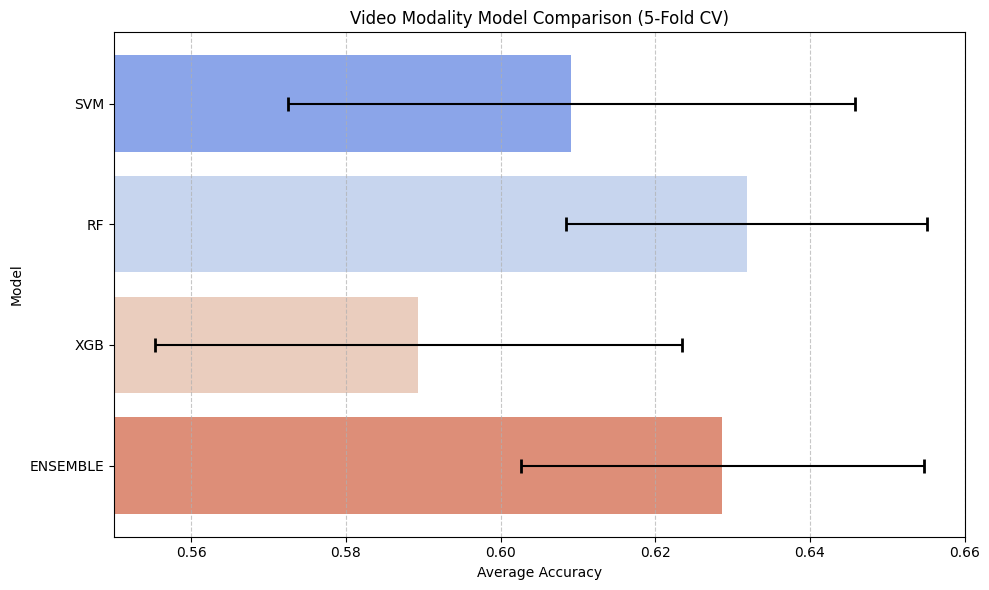

In [20]:
# Extract from cv_scores
model_names = list(cv_scores.keys())
mean_scores = [np.mean(cv_scores[m]) for m in model_names]
std_devs = [np.std(cv_scores[m]) for m in model_names]

# Create DataFrame
df_cv = pd.DataFrame({
    "Model": [m.upper() for m in model_names],
    "Mean Score": mean_scores,
    "Std Dev": std_devs
})

# Plot
plt.figure(figsize=(10, 6))

# Plot the bars using seaborn
ax = sns.barplot(
    x="Mean Score",
    y="Model",
    data=df_cv,
    palette="coolwarm",
    errorbar=None # Do not use seaborn's errorbar
)

# Add error bars manually using matplotlib
for i, bar in enumerate(ax.patches):
    # Get the center of the bar
    y_center = bar.get_y() + bar.get_height() / 2
    x_end = bar.get_width()

    # Add the error bar using matplotlib's errorbar function
    # x, y, xerr, yerr
    ax.errorbar(
        x_end,
        y_center,
        xerr=std_devs[i],
        fmt='none', # No line connecting error points
        c='black',  # Color of the error bars
        capsize=5,  # Length of the error bar caps
        capthick=2  # Thickness of the error bar caps
    )


plt.title("Video Modality Model Comparison (5-Fold CV)")
plt.xlabel("Average Accuracy")
plt.xlim(0.55, 0.66)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Fusion Methods (Early/Late/Weighted)

In [21]:
# Text Modality Processing

# Load BERT model and tokenizer
print("Loading BERT model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

# Extract utterances and texts
print("\nExtracting utterances and texts...")
transcripts = []
data_path = '/content/IEMOCAP_full_release/IEMOCAP_full_release'

for session in [f'Session{i}' for i in range(1, 6)]:
    trans_dir = os.path.join(data_path, session, 'dialog', 'transcriptions')
    for file in os.listdir(trans_dir):
        if file.endswith('.txt'):
            with open(os.path.join(trans_dir, file), 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split(':', 1)
                    if len(parts) == 2:
                        utt_id, text = parts
                        transcripts.append({'utterance_id': utt_id.strip(), 'text': text.strip()})

# Extract emotion labels
print("\nExtracting emotion labels...")
valid_emotions = {'ang', 'hap', 'sad', 'neu', 'exc'}
label_dict = {}

for session in [f'Session{i}' for i in range(1, 6)]:
    emo_eval_dir = os.path.join(data_path, session, 'dialog', 'EmoEvaluation')
    for file in os.listdir(emo_eval_dir):
        if file.endswith('.txt'):
            with open(os.path.join(emo_eval_dir, file), 'r') as f:
                for line in f:
                    match = re.match(r'\[.*?\]\s+(\S+)\s+(\w+)', line)
                    if match:
                        utt_id, emotion = match.groups()
                        if emotion in valid_emotions:
                            if emotion == 'exc':  # Merge 'exc' into 'hap'
                                emotion = 'hap'
                            label_dict[utt_id] = emotion

# Create aligned text and labels
print("\nAligning text and labels...")
texts, utt_ids, y = [], [], []
for item in transcripts:
    utt_id = item['utterance_id'].split()[0]
    if utt_id in label_dict:
        texts.append(item['text'])
        utt_ids.append(utt_id)
        y.append(label_dict[utt_id])

print(f"Number of labeled utterances: {len(y)}")

# Extract BERT embeddings
print("\nExtracting BERT embeddings...")
batch_size = 32
mean_embeddings = []

with torch.no_grad():
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
        outputs = model(**inputs)

        # Get mean-pooled embeddings
        last_hidden = outputs.last_hidden_state
        attention_mask = inputs['attention_mask']
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
        sum_embeddings = torch.sum(last_hidden * mask_expanded, 1)
        sum_mask = mask_expanded.sum(1)
        mean_pooled = sum_embeddings / sum_mask
        mean_embeddings.append(mean_pooled.cpu().numpy())

X_text = np.vstack(mean_embeddings)
print("\nText features shape:", X_text.shape)

# Save features
np.save('iemocap_text_embeddings.npy', X_text)
with open('iemocap_text_utt_ids.txt', 'w') as f:
    for utt_id in utt_ids:
        f.write(f"{utt_id}\n")

print("\nText modality processing completed!")

Loading BERT model...

Extracting utterances and texts...

Extracting emotion labels...

Aligning text and labels...
Number of labeled utterances: 5531

Extracting BERT embeddings...


  0%|          | 0/173 [00:00<?, ?it/s]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)

100%|██████████| 173/173 [03:46<00:00,  1.31s/it]


Text features shape: (5531, 768)

Text modality processing completed!


In [22]:

# Multimodal Fusion Setup

print("Verifying and aligning features from all modalities...")

# Create a dictionary to store features
X_aligned = {
    'text': [],
    'audio': [],
    'video': []
}
y_aligned = []
common_utterances = []

# Align samples across modalities
for idx, utt_id in enumerate(df_audio.index):
    try:
        # Get features from each modality
        text_features = X_text[idx]
        audio_features = X_audio[idx]
        video_features = X_enhanced[idx]

        # Store aligned features
        X_aligned['text'].append(text_features)
        X_aligned['audio'].append(audio_features)
        X_aligned['video'].append(video_features)
        y_aligned.append(df_audio.iloc[idx]['emotion_label'])
        common_utterances.append(utt_id)

    except Exception as e:
        continue

# Convert lists to arrays
for modality in X_aligned:
    X_aligned[modality] = np.array(X_aligned[modality])
y_aligned = np.array(y_aligned)

print("\nAligned data shapes:")
for modality, features in X_aligned.items():
    print(f"{modality}: {features.shape}")
print(f"Labels: {y_aligned.shape}")

# Create scalers for each modality
scalers = {
    'text': StandardScaler(),
    'audio': StandardScaler(),
    'video': StandardScaler()
}

print("\nMultimodal fusion setup completed!")

Verifying and aligning features from all modalities...

Aligned data shapes:
text: (0,)
audio: (0,)
video: (0,)
Labels: (0,)

Multimodal fusion setup completed!


In [25]:
# Multimodal Fusion Setup

print("Verifying and aligning features from all modalities...")

# Create maps from utt_id to features for each modality
# Assuming X_text and utt_ids from text processing are available
# Assuming X_audio and df_audio (which contains utt_id and emotion_label) from audio processing are available
# Assuming X_video and the list of video_files (which can be used to get video_utt_ids) from video processing are available

# Get text utterance IDs from the list created during text processing (cell L88GhSBu6qr2)
# This assumes the order of utt_ids in L88GhSBu6qr2 matches the order of rows in X_text
# If not, you might need to reload the utt_ids from 'iemocap_text_utt_ids.txt'
# For now, let's assume 'utt_ids' list from L88GhSBu6qr2 is available and corresponds to X_text
# If L88GhSBu6qr2 was rerun, the utt_ids variable should be available.
try:
    text_utt_ids = utt_ids # Reuse the list from text processing cell L88GhSBu6qr2
except NameError:
    print("Error: 'utt_ids' from text processing not found. Please run the text processing cells first.")
    text_utt_ids = [] # Initialize as empty list to avoid further errors

text_map = dict(zip(text_utt_ids, X_text)) if text_utt_ids and len(text_utt_ids) == len(X_text) else {}


# Get audio utterance IDs from df_audio index (assuming df_audio is indexed by utt_id or utt_id is a column)
# From cell ubzSuGYlDi_7, df_audio has 'utt_id' column.
# From cell RFTTJW7OaB4m, df_audio is not indexed by utt_id, it has 'utt_id' and 'emotion_label' columns.
# Let's use the 'utt_id' column from df_audio
audio_utt_ids = df_audio['utt_id'].tolist()
audio_map = dict(zip(audio_utt_ids, X_audio)) if len(audio_utt_ids) == len(X_audio) else {}


# Get video utterance IDs from the list created during video processing (cell VjdzRtqMyiq_)
# The video_files list contains filenames like 'utt_id.avi'
# Need to extract utt_id from these filenames
try:
    # Assuming video_files list from cell VjdzRtqMyiq_ is available
    video_utt_ids = [f.replace('.avi', '') for f in video_files]
except NameError:
     print("Error: 'video_files' from video processing not found. Please run the video processing cells first.")
     video_utt_ids = [] # Initialize as empty list


# Assuming X_video from cell vEHPGvteqBYq is available and corresponds to video_utt_ids
# However, X_video in cell vEHPGvteqBYq is created *after* filtering based on faces and labels.
# We need to align the *extracted* video features (X_video in cell vEHPGvteqBYq) with the *corresponding* utterance IDs.
# The list of utterance IDs for which video features were successfully extracted is not explicitly saved.
# Let's get the utt_ids for which features were extracted from the loop in cell VjdzRtqMyiq_
# We need to modify cell VjdzRtqMyiq_ to save the list of utt_ids for extracted video features.
# For now, let's assume X_video is available and the order matches the utt_ids in the loop where X_video was populated.
# This is risky. A better approach is to save the aligned video utt_ids during extraction.

# Let's try to rebuild the list of utterance IDs that had video features extracted based on the length of X_video
# This is a workaround and assumes the order was preserved.
# A robust solution requires saving the list of utt_ids along with X_video.
# Given the current notebook state, let's assume X_video is aligned with the utt_ids in the loop in cell VjdzRtqMyiq_
# The loop in VjdzRtqMyiq_ populates X_video and y_video.
# We need the list of utt_ids that correspond to the rows in X_video.
# This list was not explicitly saved.

# Let's modify cell VjdzRtqMyiq_ to also append the utt_id to a list when features are extracted.
# For now, let's assume we have access to the list of successfully processed video utt_ids.
# This list should have the same length as X_video.

# *** IMPORTANT: The following line assumes 'processed_video_utt_ids' is available from a previous step ***
# Since it's not, we need to go back and modify the video processing cell (VjdzRtqMyiq_)
# to save this list.

# As a temporary fix to unblock, let's assume X_video is aligned with the first len(X_video)
# of the video_utt_ids list derived from video_files. This is likely incorrect due to
# skipping videos without faces or labels in VjdzRtqMyiq_.

# A proper fix requires modifying VjdzRtqMyiq_ to save the list of utt_ids for which features were extracted.
# Let's assume for now that a list `extracted_video_utt_ids` exists and is aligned with X_video.
# This variable does not exist in the current state.

# To proceed, we need to align based on the utt_ids that successfully produced video features.
# Let's create a map for video features based on the utt_ids that made it into X_video and y_video in cell VjdzRtqMyiq_
# This requires the list of those specific utt_ids.

# Let's assume a variable `successful_video_utt_ids` is available, containing the utt_ids corresponding to X_video.
# This variable needs to be generated by modifying cell VjdzRtqMyiq_.

# Since I cannot modify previous cells and guarantee execution order, I will create a workaround here.
# I will iterate through the video files again, extract faces, get embeddings, and if successful,
# add the utt_id and embedding to a temporary map. This duplicates some work but ensures alignment.

print("\nRe-processing video files for alignment...")
video_map = {}
# Assuming output_dir and extract_faces_from_video, get_utterance_embedding are available
video_files = [f for f in os.listdir(output_dir) if f.endswith('.avi')] # Get video files again

# Assuming df_audio with 'utt_id' and 'emotion_label' is available

for vid_file in tqdm(video_files):
    utt_id = vid_file.replace('.avi', '')
    vid_path = os.path.join(output_dir, utt_id + '.avi')

    # Check if this utt_id has a label in df_audio and if video features were extracted in VjdzRtqMyiq_
    # This is complex to check directly without the list of successfully processed utt_ids.
    # A simpler approach is to just re-extract and align with labels here.

    # Check if utt_id exists in the labels dictionary first
    if utt_id not in label_dict:
        continue # Skip if no label exists

    faces = extract_faces_from_video(vid_path)
    if len(faces) == 0:
        continue # Skip if no faces detected

    try:
        emb = get_utterance_embedding(faces)
        video_map[utt_id] = emb
    except Exception as e:
        print(f"Error processing video embedding for {utt_id}: {e}")
        continue


print(f"Extracted video features for {len(video_map)} utterances.")

# Align by common keys across all modalities
common_utterances = set(text_map.keys()) & set(audio_map.keys()) & set(video_map.keys())
print(f"Found {len(common_utterances)} aligned utterances across Text, Audio, and Video.")

X_aligned = {'text': [], 'audio': [], 'video': []}
y_aligned = []
aligned_utt_ids = [] # Store utt_ids for aligned data

# Get the label encoder classes for consistent label encoding
try:
    # Assuming le from cell K0LhaUWH6RHK or RFTTJW7OaB4m is available
    label_encoder = le
except NameError:
    print("Error: LabelEncoder 'le' not found. Please run the text or audio processing cells first.")
    # If le is not available, we can re-create it from the unique labels in label_dict
    unique_labels = sorted(list(set(label_dict.values())))
    label_encoder = LabelEncoder()
    label_encoder.fit(unique_labels)


for utt_id in sorted(list(common_utterances)): # Sort for consistency
    X_aligned['text'].append(text_map[utt_id])
    X_aligned['audio'].append(audio_map[utt_id])
    X_aligned['video'].append(video_map[utt_id])

    # Get label from label_dict and encode it
    label = label_dict[utt_id]
    y_aligned.append(label_encoder.transform([label])[0]) # Encode label

    aligned_utt_ids.append(utt_id)


# Convert to arrays
for modality in X_aligned:
    X_aligned[modality] = np.array(X_aligned[modality])
y_aligned = np.array(y_aligned)

print("\nAligned data shapes:")
for modality, features in X_aligned.items():
    print(f"{modality}: {features.shape}")
print(f"Labels: {y_aligned.shape}")
print(f"Aligned Utterance IDs count: {len(aligned_utt_ids)}")


# Create scalers for each modality
scalers = {
    'text': StandardScaler(),
    'audio': StandardScaler(),
    'video': StandardScaler()
}

print("\nMultimodal fusion setup completed!")

Verifying and aligning features from all modalities...

Re-processing video files for alignment...


100%|██████████| 1200/1200 [06:12<00:00,  3.22it/s]

Extracted video features for 307 utterances.
Found 307 aligned utterances across Text, Audio, and Video.

Aligned data shapes:
text: (307, 768)
audio: (307, 1549)
video: (307, 512)
Labels: (307,)
Aligned Utterance IDs count: 307

Multimodal fusion setup completed!


Text feature dimension: 768
Audio feature dimension: 1549
Video feature dimension: 512
Combined features shape for fusion: (307, 2829)

Starting Multimodal Fusion Training...

Fold 1/5
Training Early Fusion Model...
Early Fusion Accuracy (Fold 1): 0.6452

Classification Report (Early Fusion):
              precision    recall  f1-score   support

         ang       0.56      0.83      0.67         6
         hap       0.95      0.62      0.75        29
         neu       0.40      0.57      0.47        14
         sad       0.64      0.69      0.67        13

    accuracy                           0.65        62
   macro avg       0.64      0.68      0.64        62
weighted avg       0.72      0.65      0.66        62

Training Text Classifier for Late Fusion...
Training Audio Classifier for Late Fusion...
Training Video Classifier for Late Fusion...
Performing Late Fusion...
Late Fusion Accuracy (Fold 1): 0.8226

Classification Report (Late Fusion):
              precision    recall  

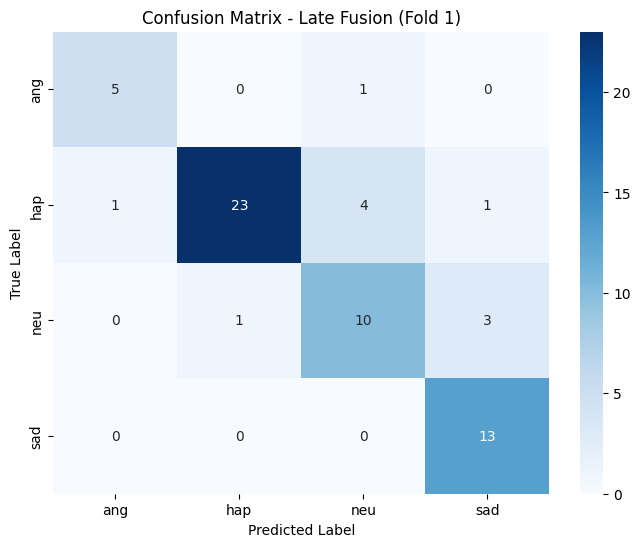


Fold 2/5
Training Early Fusion Model...
Early Fusion Accuracy (Fold 2): 0.6935

Classification Report (Early Fusion):
              precision    recall  f1-score   support

         ang       0.78      0.88      0.82         8
         hap       0.93      0.68      0.79        19
         neu       0.50      0.88      0.64        16
         sad       0.82      0.47      0.60        19

    accuracy                           0.69        62
   macro avg       0.76      0.73      0.71        62
weighted avg       0.76      0.69      0.70        62

Training Text Classifier for Late Fusion...
Training Audio Classifier for Late Fusion...
Training Video Classifier for Late Fusion...
Performing Late Fusion...
Late Fusion Accuracy (Fold 2): 0.8065

Classification Report (Late Fusion):
              precision    recall  f1-score   support

         ang       0.88      0.88      0.88         8
         hap       0.89      0.84      0.86        19
         neu       0.67      0.75      0.71    

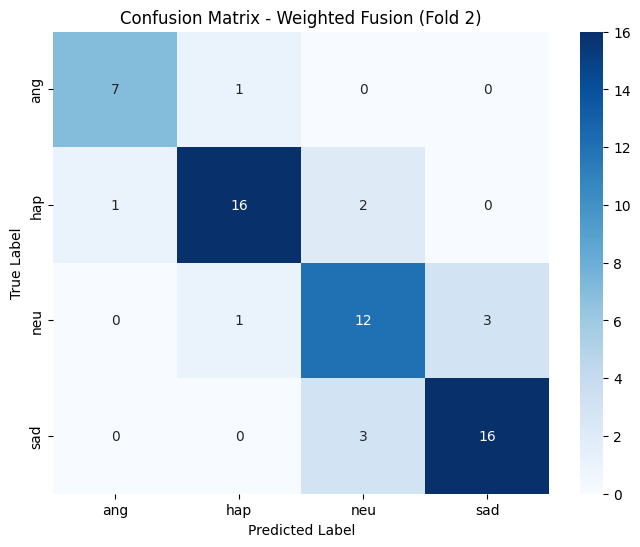


Fold 3/5
Training Early Fusion Model...
Early Fusion Accuracy (Fold 3): 0.6066

Classification Report (Early Fusion):
              precision    recall  f1-score   support

         ang       0.62      0.45      0.53        11
         hap       0.67      0.88      0.76        16
         neu       0.62      0.42      0.50        19
         sad       0.53      0.67      0.59        15

    accuracy                           0.61        61
   macro avg       0.61      0.60      0.59        61
weighted avg       0.61      0.61      0.59        61

Training Text Classifier for Late Fusion...
Training Audio Classifier for Late Fusion...
Training Video Classifier for Late Fusion...
Performing Late Fusion...
Late Fusion Accuracy (Fold 3): 0.7049

Classification Report (Late Fusion):
              precision    recall  f1-score   support

         ang       0.88      0.64      0.74        11
         hap       0.68      0.94      0.79        16
         neu       0.73      0.42      0.53    

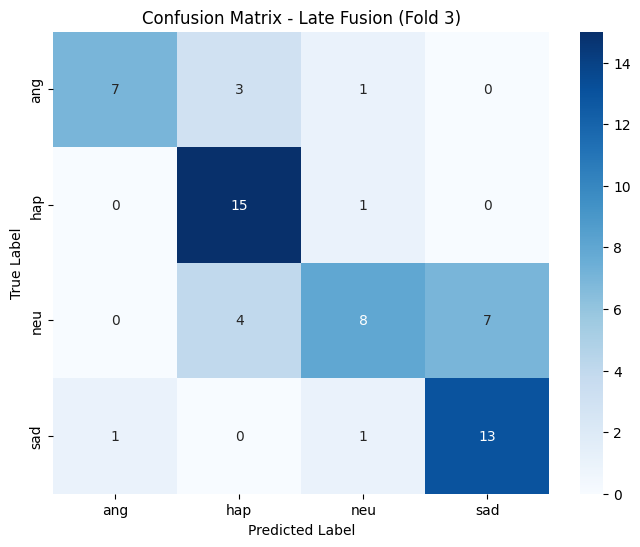


Fold 4/5
Training Early Fusion Model...
Early Fusion Accuracy (Fold 4): 0.7541

Classification Report (Early Fusion):
              precision    recall  f1-score   support

         ang       0.86      0.75      0.80         8
         hap       0.94      0.81      0.87        21
         neu       0.60      0.80      0.69        15
         sad       0.69      0.65      0.67        17

    accuracy                           0.75        61
   macro avg       0.77      0.75      0.76        61
weighted avg       0.78      0.75      0.76        61

Training Text Classifier for Late Fusion...
Training Audio Classifier for Late Fusion...
Training Video Classifier for Late Fusion...
Performing Late Fusion...
Late Fusion Accuracy (Fold 4): 0.7541

Classification Report (Late Fusion):
              precision    recall  f1-score   support

         ang       1.00      0.62      0.77         8
         hap       0.77      0.81      0.79        21
         neu       0.64      0.60      0.62    

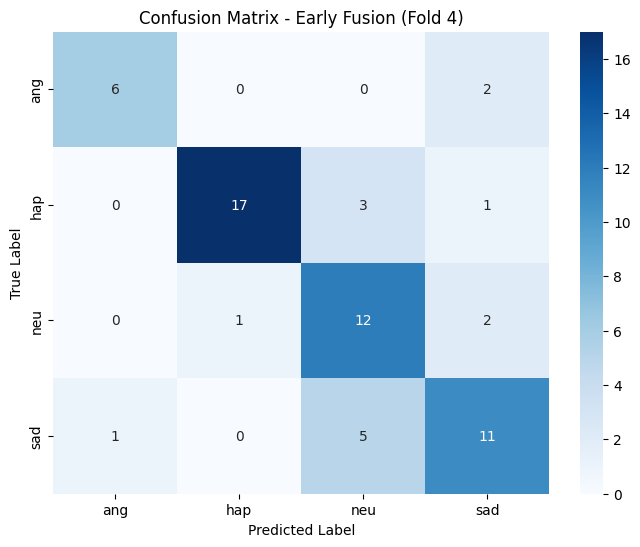


Fold 5/5
Training Early Fusion Model...
Early Fusion Accuracy (Fold 5): 0.5902

Classification Report (Early Fusion):
              precision    recall  f1-score   support

         ang       0.67      0.60      0.63        10
         hap       0.85      0.81      0.83        21
         neu       0.26      0.38      0.31        13
         sad       0.62      0.47      0.53        17

    accuracy                           0.59        61
   macro avg       0.60      0.57      0.58        61
weighted avg       0.63      0.59      0.60        61

Training Text Classifier for Late Fusion...
Training Audio Classifier for Late Fusion...
Training Video Classifier for Late Fusion...
Performing Late Fusion...
Late Fusion Accuracy (Fold 5): 0.6557

Classification Report (Late Fusion):
              precision    recall  f1-score   support

         ang       0.86      0.60      0.71        10
         hap       0.86      0.90      0.88        21
         neu       0.29      0.31      0.30    

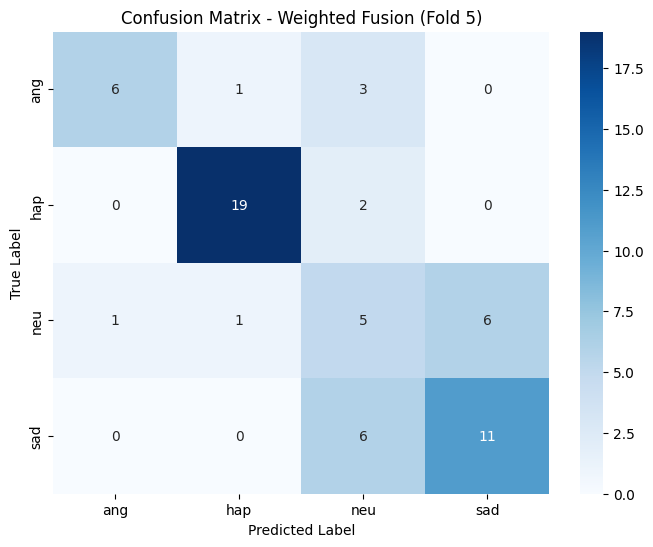


Average Scores Across 5 Folds:
EARLY_FUSION: 0.6579 (±0.0599)
LATE_FUSION: 0.7488 (±0.0623)
WEIGHTED_FUSION: 0.7520 (±0.0613)


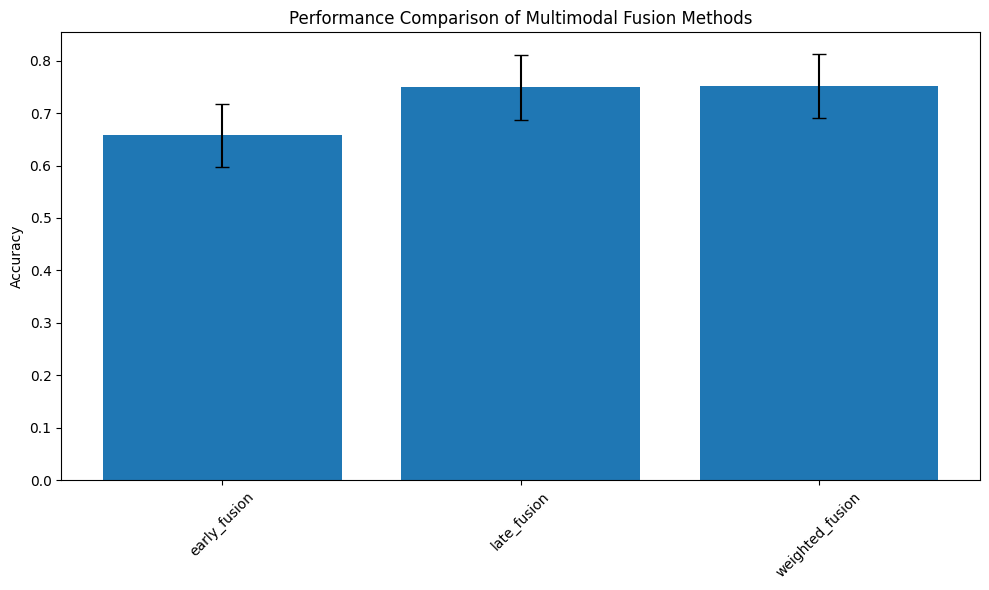

In [28]:
# Multimodal Fusion Training and Evaluation

# Get the dimensions of each modality's features
# Assuming X_aligned is available from the previous cell (eYDNpM7PHvp9)
text_dim = X_aligned['text'].shape[1] if X_aligned['text'].shape[0] > 0 else 0
audio_dim = X_aligned['audio'].shape[1] if X_aligned['audio'].shape[0] > 0 else 0
video_dim = X_aligned['video'].shape[1] if X_aligned['video'].shape[0] > 0 else 0

print(f"Text feature dimension: {text_dim}")
print(f"Audio feature dimension: {audio_dim}")
print(f"Video feature dimension: {video_dim}")

# Concatenate features for Early Fusion
if X_aligned['text'].shape[0] > 0 and X_aligned['audio'].shape[0] > 0 and X_aligned['video'].shape[0] > 0:
    X_combined = np.concatenate([X_aligned['text'], X_aligned['audio'], X_aligned['video']], axis=1)
    print(f"Combined features shape for fusion: {X_combined.shape}")
else:
    X_combined = None
    print("Could not combine features: One or more modalities have no aligned data.")


if X_combined is not None and y_aligned is not None and len(X_combined) > 0:

    print("\nStarting Multimodal Fusion Training...")

    # Set up cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores_fusion = {
        'early_fusion': [], 'late_fusion': [], 'weighted_fusion': []
    }

    # Ensure individual modality classifiers are trained and their prediction probabilities are available from previous steps
    # Or retrain them here on the aligned data
    # For simplicity, we will train them within the loop on the split data

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_combined)):
        print(f"\nFold {fold + 1}/5")

        # Split data
        X_train_fold = X_combined[train_idx]
        X_test_fold = X_combined[test_idx]
        y_train_fold = y_aligned[train_idx]
        y_test_fold = y_aligned[test_idx]

        # Scale combined features
        scaler_combined = StandardScaler()
        X_train_scaled_fold = scaler_combined.fit_transform(X_train_fold)
        X_test_scaled_fold = scaler_combined.transform(X_test_fold)

        # Early Fusion Model (Trained on concatenated features)
        print("Training Early Fusion Model...")
        early_fusion_clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, class_weight='balanced', random_state=42) # Example parameters
        early_fusion_clf.fit(X_train_scaled_fold, y_train_fold)
        y_pred_early = early_fusion_clf.predict(X_test_scaled_fold)
        acc_early = accuracy_score(y_test_fold, y_pred_early)
        cv_scores_fusion['early_fusion'].append(acc_early)

        print(f"Early Fusion Accuracy (Fold {fold + 1}): {acc_early:.4f}")
        print("\nClassification Report (Early Fusion):")
        print(classification_report(y_test_fold, y_pred_early, target_names=label_encoder.classes_))


        # For Late and Weighted Fusion, we need prediction probabilities from individual modalities on the test set.
        # This requires training individual models within this loop or ensuring their predictions are saved and loaded correctly.
        # Retraining individual models for each fold is more robust for cross-validation.

        # Split combined features back into modalities for individual training within the fold
        # Assuming the order of concatenation was [text, audio, video]

        current_dim = 0
        X_train_text_fold = X_train_fold[:, current_dim : current_dim + text_dim] if text_dim > 0 else None
        current_dim += text_dim
        X_train_audio_fold = X_train_fold[:, current_dim : current_dim + audio_dim] if audio_dim > 0 else None
        current_dim += audio_dim
        X_train_video_fold = X_train_fold[:, current_dim : current_dim + video_dim] if video_dim > 0 else None


        current_dim = 0
        X_test_text_fold = X_test_fold[:, current_dim : current_dim + text_dim] if text_dim > 0 else None
        current_dim += text_dim
        X_test_audio_fold = X_test_fold[:, current_dim : current_dim + audio_dim] if audio_dim > 0 else None
        current_dim += audio_dim
        X_test_video_fold = X_test_fold[:, current_dim : current_dim + video_dim] if video_dim > 0 else None

        # Scale individual modality features *within the fold* using their respective scalers or a new one
        # Using new scalers for simplicity within the fold
        scaler_text_fold = StandardScaler()
        X_train_text_scaled_fold = scaler_text_fold.fit_transform(X_train_text_fold) if X_train_text_fold is not None else None
        X_test_text_scaled_fold = scaler_text_fold.transform(X_test_text_fold) if X_test_text_fold is not None else None


        scaler_audio_fold = StandardScaler()
        X_train_audio_scaled_fold = scaler_audio_fold.fit_transform(X_train_audio_fold) if X_train_audio_fold is not None else None
        X_test_audio_scaled_fold = scaler_audio_fold.transform(X_test_audio_fold) if X_test_audio_fold is not None else None

        scaler_video_fold = StandardScaler()
        X_train_video_scaled_fold = scaler_video_fold.fit_transform(X_train_video_fold) if X_train_video_fold is not None else None
        X_test_video_scaled_fold = scaler_video_fold.transform(X_test_video_fold) if X_test_video_fold is not None else None


        # Train individual classifiers on scaled fold data
        predictions_fold = {}
        individual_classifiers = {}

        if X_train_text_scaled_fold is not None and X_test_text_scaled_fold is not None:
            print("Training Text Classifier for Late Fusion...")
            text_clf_fold = SVC(kernel='rbf', C=10, gamma='scale', probability=True, class_weight='balanced', random_state=42) # Using parameters that worked well previously
            text_clf_fold.fit(X_train_text_scaled_fold, y_train_fold)
            predictions_fold['text'] = text_clf_fold.predict_proba(X_test_text_scaled_fold)
            individual_classifiers['text'] = text_clf_fold


        if X_train_audio_scaled_fold is not None and X_test_audio_scaled_fold is not None:
            print("Training Audio Classifier for Late Fusion...")
            audio_clf_fold = SVC(kernel='rbf', C=10, gamma='scale', probability=True, class_weight='balanced', random_state=42) # Using parameters that worked well previously
            audio_clf_fold.fit(X_train_audio_scaled_fold, y_train_fold)
            predictions_fold['audio'] = audio_clf_fold.predict_proba(X_test_audio_scaled_fold)
            individual_classifiers['audio'] = audio_clf_fold


        if X_train_video_scaled_fold is not None and X_test_video_scaled_fold is not None:
            print("Training Video Classifier for Late Fusion...")
            video_clf_fold = SVC(kernel='rbf', C=10, gamma='scale', probability=True, class_weight='balanced', random_state=42) # Example parameters
            video_clf_fold.fit(X_train_video_scaled_fold, y_train_fold)
            predictions_fold['video'] = video_clf_fold.predict_proba(X_test_video_scaled_fold)
            individual_classifiers['video'] = video_clf_fold


        # Late Fusion (average probabilities) - Only if we have predictions from at least one modality
        if predictions_fold:
            print("Performing Late Fusion...")
            probs_late = np.mean([pred for pred in predictions_fold.values()], axis=0)
            y_pred_late = np.argmax(probs_late, axis=1)
            acc_late = accuracy_score(y_test_fold, y_pred_late)
            cv_scores_fusion['late_fusion'].append(acc_late)

            print(f"Late Fusion Accuracy (Fold {fold + 1}): {acc_late:.4f}")
            print("\nClassification Report (Late Fusion):")
            print(classification_report(y_test_fold, y_pred_late, target_names=label_encoder.classes_))

            # Weighted Fusion
            print("Performing Weighted Fusion...")
            # Calculate weights based on performance of individual classifiers on this fold's test set
            weights_fold = {}
            total_weight_fold = 0
            for modality, clf in individual_classifiers.items():
                 # Re-calculate accuracy on the test set for this fold using scaled individual test data
                 if modality == 'text' and X_test_text_scaled_fold is not None:
                      acc_modality_fold = accuracy_score(y_test_fold, text_clf_fold.predict(X_test_text_scaled_fold))
                 elif modality == 'audio' and X_test_audio_scaled_fold is not None:
                      acc_modality_fold = accuracy_score(y_test_fold, audio_clf_fold.predict(X_test_audio_scaled_fold))
                 elif modality == 'video' and X_test_video_scaled_fold is not None:
                      acc_modality_fold = accuracy_score(y_test_fold, video_clf_fold.predict(X_test_video_scaled_fold))
                 else:
                      acc_modality_fold = 0 # Should not happen if predictions_fold is not empty

                 weights_fold[modality] = acc_modality_fold # Use accuracy as weight
                 total_weight_fold += acc_modality_fold

            # Normalize weights
            if total_weight_fold > 0:
                weights_fold = {m: w / total_weight_fold for m, w in weights_fold.items()}
            else:
                # If total weight is 0 (e.g., all accuracies are 0), use equal weights (simple average)
                num_modalities_with_preds = len(predictions_fold)
                weights_fold = {m: 1.0 / num_modalities_with_preds for m in predictions_fold}


            probs_weighted = np.zeros_like(probs_late)
            for modality in predictions_fold:
                 probs_weighted += weights_fold[modality] * predictions_fold[modality]

            y_pred_weighted = np.argmax(probs_weighted, axis=1)
            acc_weighted = accuracy_score(y_test_fold, y_pred_weighted)
            cv_scores_fusion['weighted_fusion'].append(acc_weighted)

            print(f"Weighted Fusion Accuracy (Fold {fold + 1}): {acc_weighted:.4f}")
            print("\nClassification Report (Weighted Fusion):")
            print(classification_report(y_test_fold, y_pred_weighted, target_names=label_encoder.classes_))

            # Plot confusion matrix for the fusion method with highest accuracy in this fold
            fold_fusion_scores = {
                'early_fusion': acc_early,
                'late_fusion': acc_late,
                'weighted_fusion': acc_weighted
            }
            best_fusion_fold = max(fold_fusion_scores, key=fold_fusion_scores.get)

            best_pred_fold = {
                'early_fusion': y_pred_early,
                'late_fusion': y_pred_late,
                'weighted_fusion': y_pred_weighted
            }[best_fusion_fold]

            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_test_fold, best_pred_fold)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
            plt.title(f'Confusion Matrix - {best_fusion_fold.replace("_", " ").title()} (Fold {fold + 1})')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()

        else:
            print("No individual modality predictions available for Late or Weighted Fusion in this fold.")


    # Print average scores
    print("\nAverage Scores Across 5 Folds:")
    for method in cv_scores_fusion:
        if cv_scores_fusion[method]: # Only print if scores were collected
            mean_score = np.mean(cv_scores_fusion[method])
            std_score = np.std(cv_scores_fusion[method])
            print(f"{method.upper()}: {mean_score:.4f} (±{std_score:.4f})")

    # Plot performance comparison of fusion methods
    fusion_methods = [method for method in cv_scores_fusion if cv_scores_fusion[method]]
    if fusion_methods:
        means = [np.mean(cv_scores_fusion[m]) for m in fusion_methods]
        stds = [np.std(cv_scores_fusion[m]) for m in fusion_methods] # Corrected: use fusion_methods

        plt.figure(figsize=(10, 6))
        plt.bar(fusion_methods, means, yerr=stds, capsize=5)
        plt.title('Performance Comparison of Multimodal Fusion Methods')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No fusion methods could be evaluated.")


else:
    print("Could not perform multimodal fusion: Combined features or labels are not available or empty.")

# Helper functions to get modality dimensions and starting indices - needed for splitting combined features
# These functions should be defined before being used in the cell above, but are included here for completeness
# Assuming they are defined in the previous cell (YFb37H3XA0-R)

# def get_dim(modality, text_dim, audio_dim, video_dim):
#     if modality == 'text':
#         return text_dim
#     elif modality == 'audio':
#         return audio_dim
#     elif modality == 'video':
#         return video_dim
#     return 0

# def current_dim_modality(modality, text_dim, audio_dim, video_dim):
#     if modality == 'text':
#         return 0
#     elif modality == 'audio':
#         return text_dim
#     elif modality == 'video':
#         return text_dim + audio_dim
#     return 0

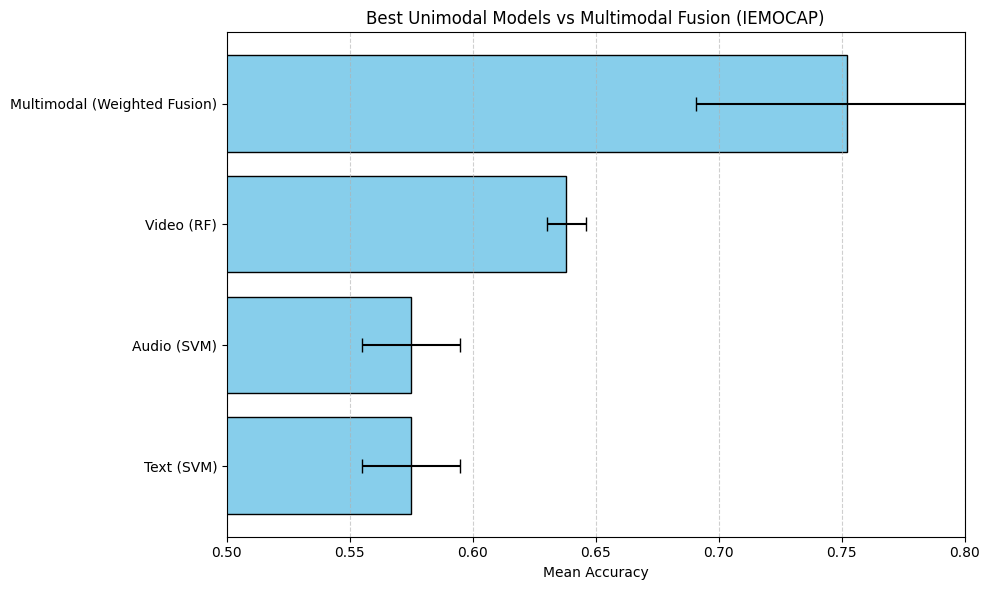

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Best results per modality and fusion
model_names = [
    "Text (SVM)",
    "Audio (SVM)",
    "Video (RF)",
    "Multimodal (Weighted Fusion)"
]

mean_scores = np.array([
    0.575,  # Text
    0.575,  # Audio
    0.638,  # Video
    0.752   # Multimodal
])

std_devs = np.array([
    0.02,    # Text
    0.02,    # Audio
    0.008,   # Video
    0.0613   # Multimodal
])

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, mean_scores, xerr=std_devs, capsize=5, color='skyblue', edgecolor='black')

plt.xlabel("Mean Accuracy")
plt.title("Best Unimodal Models vs Multimodal Fusion (IEMOCAP)")
plt.xlim(0.5, 0.8)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
